In [222]:
#using these guides
#https://medium.com/swlh/a-technical-guide-on-rnn-lstm-gru-for-stock-price-prediction-bce2f7f30346
#https://github.com/dataman-git/codes_for_articles/blob/master/From%20regression%20to%20RNN.ipynb
#https://datascience.stackexchange.com/questions/93180/trying-to-extend-this-code-to-include-additional-feature-volume-in-addition-to
#https://datascience.stackexchange.com/questions/91147/problems-to-understand-how-to-create-the-input-data-for-time-series-forecasting/92395?noredirect=1#comment97317_92395
#https://towardsdatascience.com/recurrent-neural-networks-for-electricity-price-prediction-a26f8411ea44
#https://github.com/Carterbouley/ElectricityPricePrediction
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [223]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [224]:
import pandas as pd
import yfinance as yf
import numpy as np
import sklearn
from yahoofinancials import YahooFinancials
AMZN = yf.download('GOLD', 
                      start='2013-01-01', 
                      progress=False)
# AMZN = yf.download('AMZN') for all 
all_data = AMZN[['Adj Close','Volume']].round(2)
#all_data = AMZN[['Adj Close']].round(2)
all_data.head(10)

,Adj Close,Volume
Date,,
2013-01-02,257.31,3271000
2013-01-03,258.48,2750900
2013-01-04,259.15,1874200
2013-01-07,268.46,4910000
2013-01-08,266.38,3010700
2013-01-09,266.35,2265600
2013-01-10,265.34,2863400
2013-01-11,267.94,2413300
2013-01-14,272.73,4275000


In [225]:
len(all_data)
#len(all_data.columns)


1761

In [226]:
import tensorflow as tf

from tensorflow import keras
from matplotlib import pyplot as plt

# Read the data for the parameters from a csv file
import urllib.request
#Delete the first column as it is not used in the tutorial for forecasting

n_steps = 512
n_ahead = 1

training = ((len(all_data)-n_steps-n_ahead)*.714)
validation = ((len(all_data)-n_steps-n_ahead)*.856)

from sklearn.preprocessing import MinMaxScaler
sc1 = MinMaxScaler(feature_range=(0,1))
#sc2 = MinMaxScaler(feature_range=(0,1))
#can handle both features!
ts_train_scaled_1 = sc1.fit_transform(all_data.iloc[:, 0:][0:int(validation)])
ts_test_scaled_1 = sc1.transform(all_data.iloc[:, 0:][int(validation):])

#data = all_data.values
#ts_train_scaled_1 = sc1.fit_transform(all_data.iloc[:, 1][0:int(training)])
#data = np.concatenate((ts_train_scaled_1, all_data[int(validation):].values), axis=0)
data = np.concatenate((ts_train_scaled_1, ts_test_scaled_1), axis=0)

series_reshaped =  np.array([data[i:i + (n_steps+n_ahead)].copy() for i in range(len(data) - (n_steps+n_ahead))])
#series_reshaped2 =  np.array([all_data.values[i:i + (n_steps+n_ahead)].copy() for i in range(len(all_data.values) - (n_steps+n_ahead))])

X_train = series_reshaped[:int(training), :n_steps] 
X_valid = series_reshaped[int(training):int(validation), :n_steps] 
X_test = series_reshaped[int(validation):, :n_steps] 

#assumes first column?
#based on https://raw.githubusercontent.com/Carterbouley/ElectricityPricePrediction/master/re_fixed_multivariate_timeseires.csv
#price is 1st column
Y = np.empty(((len(all_data) - n_steps - n_ahead), n_steps, n_ahead))  
for step_ahead in range(1, n_ahead + 1):     
   Y[..., step_ahead - 1] =   series_reshaped[..., step_ahead:step_ahead + n_steps, 0]
    
Y_train = Y[:int(training)] 
Y_valid = Y[int(training):int(validation)] 
Y_test = Y[int(validation):]

np.random.seed(42)
tf.random.set_seed(42)

model6 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, len(all_data.columns)]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))
])

model6.compile(loss="mean_squared_error", optimizer="adam", metrics=['mean_absolute_percentage_error'])
history = model6.fit(X_train, Y_train, epochs=30,batch_size=64,
                    validation_data=(X_valid, Y_valid))



Epoch 1/30
14/14 [==============================] - 4s 174ms/step - loss: 0.4195 - mean_absolute_percentage_error: 55344.5607 - val_loss: 0.7760 - val_mean_absolute_percentage_error: 32.1427
Epoch 2/30
14/14 [==============================] - 2s 150ms/step - loss: 0.0875 - mean_absolute_percentage_error: 46704.1415 - val_loss: 0.9257 - val_mean_absolute_percentage_error: 39.7753
Epoch 3/30
14/14 [==============================] - 2s 148ms/step - loss: 0.0495 - mean_absolute_percentage_error: 55432.5458 - val_loss: 0.5513 - val_mean_absolute_percentage_error: 25.8551
Epoch 4/30
14/14 [==============================] - 2s 147ms/step - loss: 0.0281 - mean_absolute_percentage_error: 57658.3419 - val_loss: 0.4558 - val_mean_absolute_percentage_error: 22.8528
Epoch 5/30
14/14 [==============================] - 2s 147ms/step - loss: 0.0206 - mean_absolute_percentage_error: 45875.9723 - val_loss: 0.3692 - val_mean_absolute_percentage_error: 20.2787
Epoch 6/30
14/14 [===========================

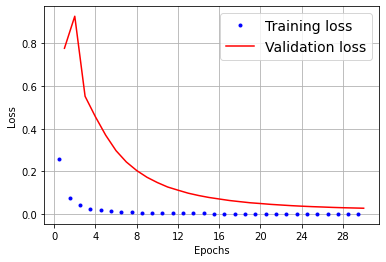

In [227]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [228]:
# - scaler   = the scaler object (it needs an inverse_transform method)
# - data     = the data to be inverse transformed as a Series, ndarray, ... 
#              (a 1d object you can assign to a df column)
# - ftName   = the name of the column to which the data belongs
# - colNames = all column names of the data on which scaler was fit 
#              (necessary because scaler will only accept a df of the same shape as the one it was fit on)
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values


In [229]:
Y_pred = model6.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][n_ahead-1]))
    
actual = pd.DataFrame((sc1.inverse_transform(X_test[:,0])))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['predictions'] = invTransform(sc1,actual["predictions"],"Adj Close",all_data.columns)
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100


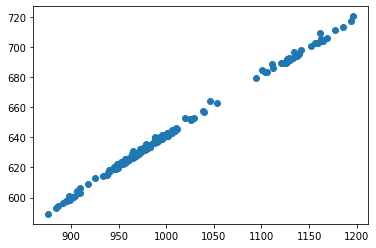

In [230]:
import matplotlib.pyplot as plt
plt.scatter(actual["actual"],actual["predictions"])

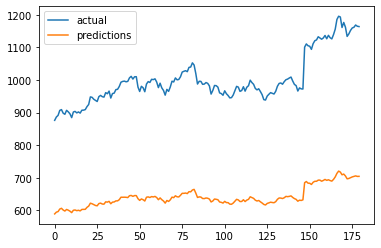

In [231]:
from matplotlib import pyplot as plt
plt.plot(actual["actual"],label="actual")
plt.plot(actual["predictions"],label="predictions")
plt.legend()
plt.show()